# 第一部分：產生蒙地卡羅結果

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import math
import random
import numpy as np

df1 = pd.read_csv('/Users/Kang/Documents/碩一下學期/張森林 機器人理財專題研究/HW1/Betterment.csv', index_col = 'Date')
df2 = pd.read_csv('/Users/Kang/Documents/碩一下學期/張森林 機器人理財專題研究/HW1/WiseBanyan.csv', index_col = 'Date')
df3 = pd.read_csv('/Users/Kang/Documents/碩一下學期/張森林 機器人理財專題研究/HW1/Charles_Schwab.csv', index_col = 'Date')
df4 = pd.read_csv('/Users/Kang/Documents/碩一下學期/張森林 機器人理財專題研究/HW1/Ellevest.csv', index_col = 'Date')

df1 = df1.set_index(pd.DatetimeIndex(df1.index))
df2 = df2.set_index(pd.DatetimeIndex(df2.index))
df3 = df3.set_index(pd.DatetimeIndex(df3.index))
df4 = df4.set_index(pd.DatetimeIndex(df4.index))

#df1.set_index("Date", inplace=True)
#df2.set_index("Date", inplace=True)
#df3.set_index("Date", inplace=True)
#df4.set_index("Date", inplace=True)

all_frame = [df1, df2, df3, df4]
name = ['Betterment', 'WiseBanyan', 'Charles_Schwab', 'Ellevest']

In [2]:
#隨機抽樣
def gen_wei(num):
    mylist = []
    for i in range(num):
        mylist.append(random.random())
    
    s = sum(mylist)
    for j in range(num):
        mylist[j] = mylist[j] / s
    
    #10次方
    mylist = [i**10 / sum(i**10 for i in mylist) for i in mylist]
    
    return mylist

In [3]:
#常態可放空抽樣
def gen_std_wei(num):
    mylist = np.random.standard_normal(num).tolist()
    
    s = sum(mylist)
    for j in range(num):
        mylist[j] = mylist[j] + ((1 - s) / num)
    
    return mylist

In [4]:
begin_invest = 10000

def gen_result(dataframe, times = 1000):
    
    #透過輸入的dataframe取得columns
    title = dataframe.columns.tolist()
    
    #建立一個新的dataframe來存隨機資料
    df = pd.DataFrame()
    
    #再用另一個dataframe來存前一資料裡，每次隨機所產生的期望值、標準差
    result = pd.DataFrame(columns = ('stdev', 'mean'))
    
    #隨機次數
    for t in range(times):
        
        #每次隨機均利用先前函數，重新生成一組權重
        weight = gen_wei(len(title))
        weight = [begin_invest * i for i in weight]
        weight = weight / dataframe.iloc[0]
        
        #將每一檔商品乘上權重，為一個單位之價值，並且取變化百分比（報酬率）
        df[t] = sum(dataframe[k] * weight[k] for k in title)
        
        #計算出報酬率之平均及標準差，加入result裡
        result = result.append({'stdev' : df[t].pct_change().std() * math.sqrt(252), 'mean' : df[t].pct_change().mean() * 252}, ignore_index = True)
        
    return result

How many times of MonteCarlo you want for each company? 10000


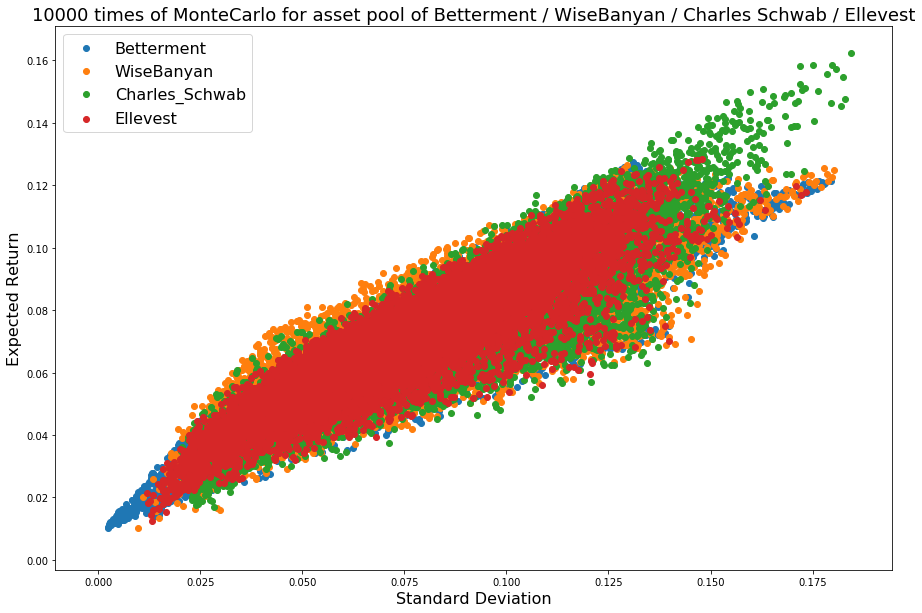

In [5]:
times = input('How many times of MonteCarlo you want for each company? ')
all_data = {}
plt.figure(figsize=(15,10))

for no in range(len(all_frame)):
    
    #將四家公司投組逐一代入gen_result裡產生蒙地卡羅結果，生成test行並排列
    result =  gen_result(all_frame[no], int(times))
    result['test'] = round(result['stdev'], 3)
    result = result[['test', 'stdev', 'mean']]
    #res = result.sort_values(by=['test'])
    
    #將結果存到一個字典裡，用公司名當key
    all_data[name[no]] = result
    
    #畫圖，最後一起print出
    plt.scatter(result['stdev'], result['mean'])

#產生圖之資訊
plt.legend(name, loc = 'best', prop = {'size' : 16})
plt.xlabel('Standard Deviation', size = 16)
plt.ylabel('Expected Return', size = 16)

if times == "":
    plt.title('1000 times of MonteCarlo for asset pool of Betterment / WiseBanyan / Charles Schwab / Ellevest', size = 18)
else:
    plt.title(times + ' times of MonteCarlo for asset pool of Betterment / WiseBanyan / Charles Schwab / Ellevest', size = 18)

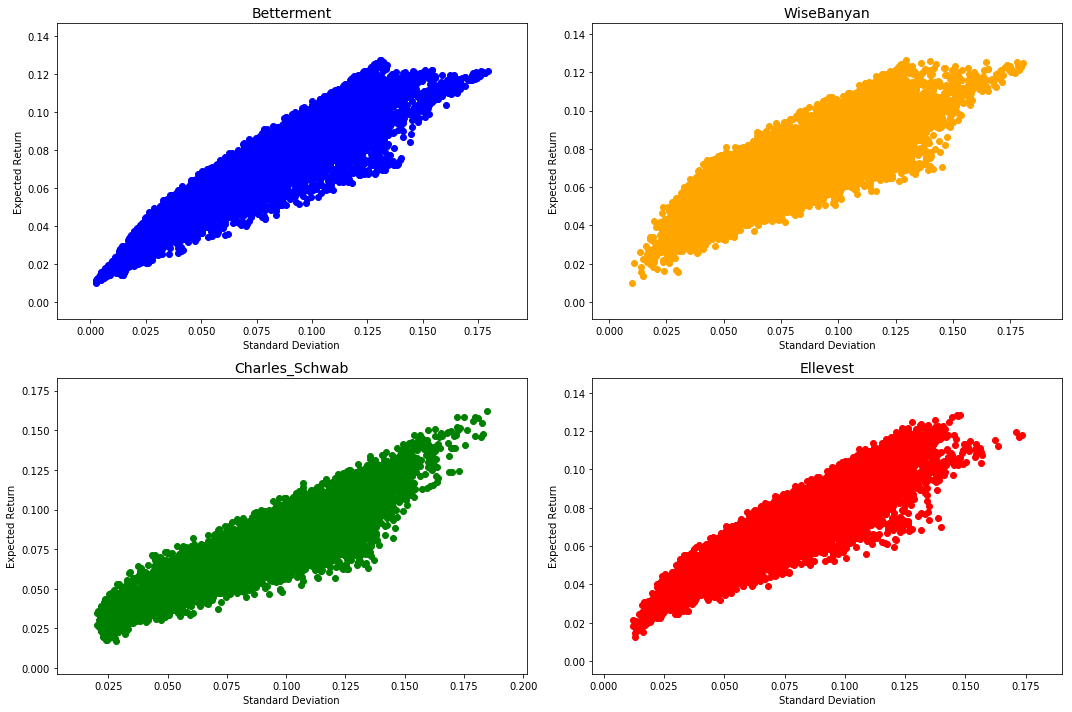

In [6]:
f, ax = plt.subplots(2, 2, figsize=(15,10))

ax[0,0].scatter(all_data[name[0]]['stdev'], all_data[name[0]]['mean'], c = 'blue')
ax[0,1].scatter(all_data[name[1]]['stdev'], all_data[name[1]]['mean'], c = 'orange')
ax[1,0].scatter(all_data[name[2]]['stdev'], all_data[name[2]]['mean'], c = 'green')
ax[1,1].scatter(all_data[name[3]]['stdev'], all_data[name[3]]['mean'], c = 'red')

for i in [0, 1]:
    for j in [0, 1]:
        ax[i,j].set_xlabel('Standard Deviation')
        ax[i,j].set_ylabel('Expected Return')
        ax[i,j].set_title(name[(i + 1 if i == 1 else i) + j], size = 14)

plt.tight_layout()

# 第二部分：畫出效率前緣

In [7]:
#range的小數版
def frange(start, stop=None, step=None):
    #Use float number in range() function
    # if stop and step argument is null set start=0.0 and step = 1.0
    if stop == None:
        stop = start + 0.0
        start = 0.0
    if step == None:
        step = 1.0
    while True:
        if step > 0 and start >= stop:
            break
        elif step < 0 and start <= stop:
            break
        yield ("%g" % start) # return float number
        start = start + step

In [8]:
def get_line_graph(result):
    plot = pd.DataFrame(columns = ('stdev', 'mean'))

    for i in frange(result.test.min(), result.test.max(), 0.001):
        if float(i) in result['test'].tolist():
            m = result.loc[result['test'] == float(i), 'mean'].values.max()
            s = result.loc[result['mean'] == m, 'stdev'].values[0]
            plot = plot.append({'stdev' : s, 'mean' : m}, ignore_index = True)
        else:
            pass
    return plot

Text(0, 0.5, 'Expected Return')

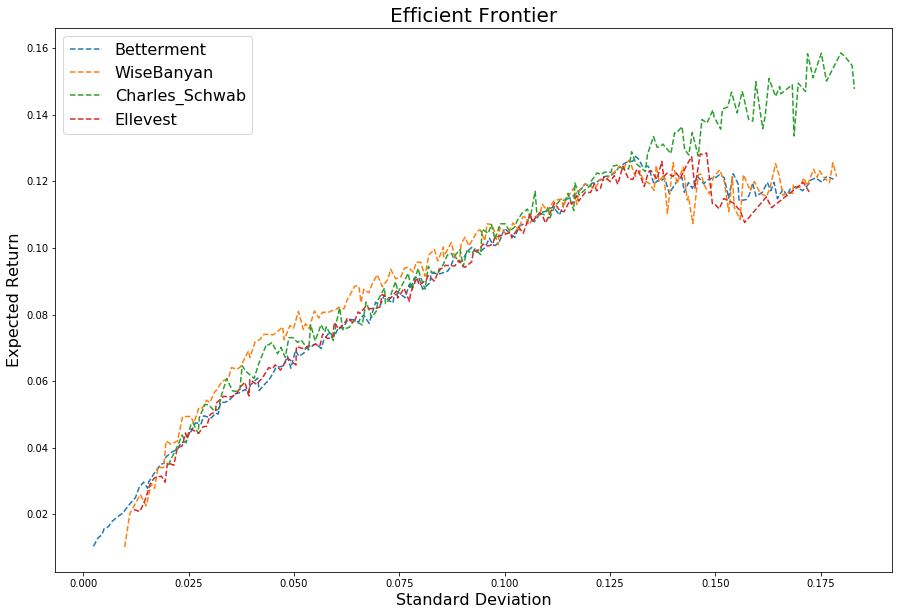

In [9]:
plt.figure(figsize=(15,10))
for no in range(len(all_data)):
    
    #用先前蒙地卡羅結果畫出效率前緣，一起印出來
    plot = get_line_graph(all_data[name[no]])
    x = plot['stdev']
    y = plot['mean']
    plt.plot(x , y, '--')

plt.title('Efficient Frontier', size = 20)
plt.legend(name, loc = 'best', prop = {'size' : 16})
plt.xlabel('Standard Deviation', size = 16)
plt.ylabel('Expected Return', size = 16)

In [10]:
#all_data[name[0]].sort_values(by=['test'])

In [11]:
result.head()

,test,stdev,mean
0,0.069,0.068698,0.068955
1,0.088,0.088099,0.077516
2,0.032,0.032244,0.033439
3,0.065,0.064868,0.048360
4,0.087,0.087230,0.082997


In [12]:
result.tail()

,test,stdev,mean
9995,0.093,0.093263,0.090117
9996,0.054,0.054078,0.047571
9997,0.069,0.068649,0.060585
9998,0.088,0.088043,0.074257
9999,0.045,0.045376,0.044624
